# Line ratios from saved moment images with PZ cube

In this notebook, I will work with only pre-calculated line maps, which have already been extracted from the cube.  The extraction process is carried out in the PZ-03 series of notebooks.

In [1]:
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from mpdaf.obj import Image
import regions
import sys
import pandas as pd
import cmasher as cmr
import pyneb as pn

sns.set_context("talk")
sns.set_color_codes()

## Path to the root of this repo

In [3]:
ROOT = Path.cwd().parent.parent

## Calculate reddening from Balmer decrement

In [4]:
# Load the Hα and Hβ maps
imha = Image(str(ROOT / "data/ngc346-PZ-hi-6563-bin01-sum.fits"))

In [5]:
imhb = Image(str(ROOT / "data/ngc346-PZ-hi-4861-bin01-sum.fits"))

### Look at the raw Hα/Hβ ratio:

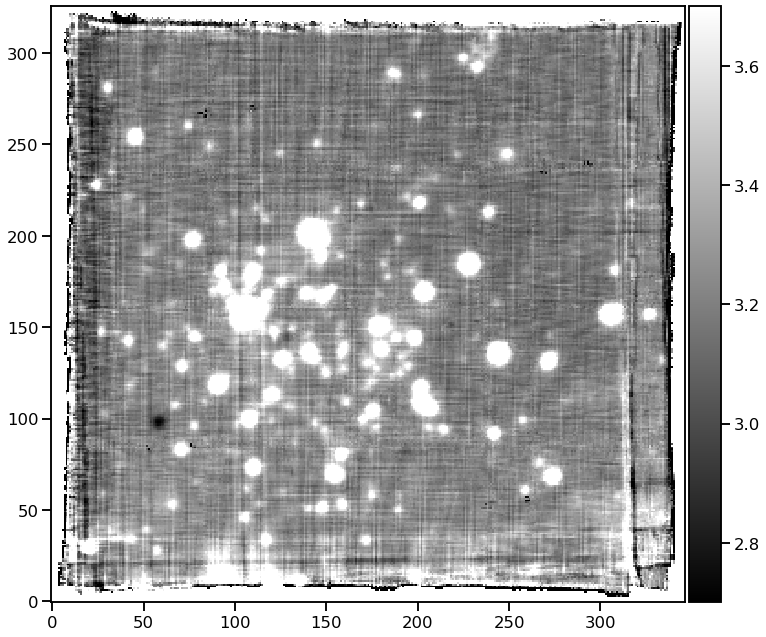

In [19]:
fig, ax = plt.subplots(figsize=(12, 12))
(imha / imhb).plot(vmin=2.7, vmax=3.7, cmap="gray", colorbar="v")

So we see very little structure there, compared with in the ESO pipeline cube case.  In priniciple, lighter means more extinction.  There might be a hint of this at the bottom of the image, where we see possible signs of the foreground filament.

But in other parts, we just see the stars (which have a different ratio because of photospheric absorption)

### PyNeb calculation of intrinsic Balmer decrement

In [7]:
hi = pn.RecAtom("H", 1)

Calculate the theoretical Balmer decrement from PyNeb. Density and temperature from Valerdi:2019a

In [8]:
tem, den = 12500, 100
R0 = hi.getEmissivity(tem, den, wave=6563) / hi.getEmissivity(tem, den, wave=4861)
R0

2.8205128205128207

### Look at correlation between Hα and Hβ in the faint limit

To make thinks easier, I multiply the Hb values by R0 so we have a square plot.  I zoom in on the faint parts:

In [13]:
imax = 100000
m = imha.data < imax
m = m & (R0 * imhb.data < imax)
m = m & ~imha.mask & ~imhb.mask
df = pd.DataFrame(
    {
        "ha": imha.data[m],
        "hb": R0 * imhb.data[m],
    }
)

Text(0.5, 0.98, 'Correlation between Ha and Hb brightness')

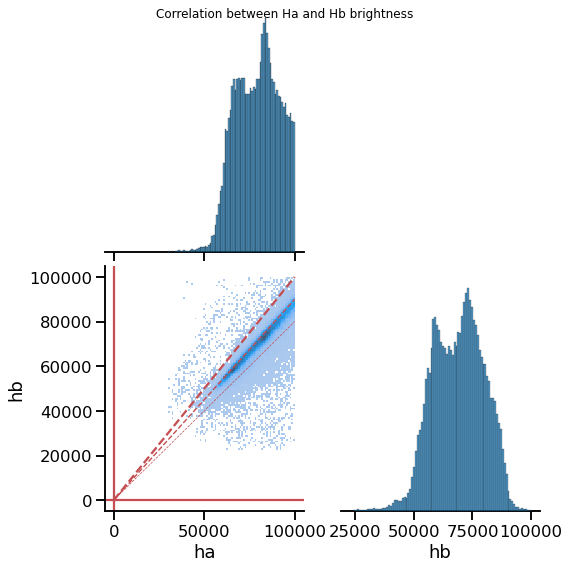

In [17]:
g = sns.pairplot(
    df,
    kind="hist",
    height=4,
    corner=True,
)
g.axes[1, 0].axvline(0.0, color="r")
g.axes[1, 0].axhline(0.0, color="r")
g.axes[1, 0].plot([0, imax], [0, imax], "--", color="r")
g.axes[1, 0].plot([0, imax], [0, 0.9 * imax], "--", color="r", linewidth=1.4)
g.axes[1, 0].plot([0, imax], [0, 0.8 * imax], "--", color="r", linewidth=0.7)
g.fig.suptitle("Correlation between Ha and Hb brightness")

So, the slope is not unity, meaning the extinction is not zero.  But the intercept is zero, which is great. So nothing more to do,

Now define some regions to take averages

In [23]:
boxes = {
    "sw filament": regions.BoundingBox(
        iymin=20,
        iymax=40,
        ixmin=200,
        ixmax=310,
    ),
    "bow shock": regions.BoundingBox(
        iymin=165,
        iymax=205,
        ixmin=240,
        ixmax=290,
    ),
    "w filament": regions.BoundingBox(
        iymin=100,
        iymax=130,
        ixmin=25,
        ixmax=55,
    ),
    "c filament": regions.BoundingBox(
        iymin=195,
        iymax=210,
        ixmin=155,
        ixmax=195,
    ),
}

Plot on a better scale and show the regions:

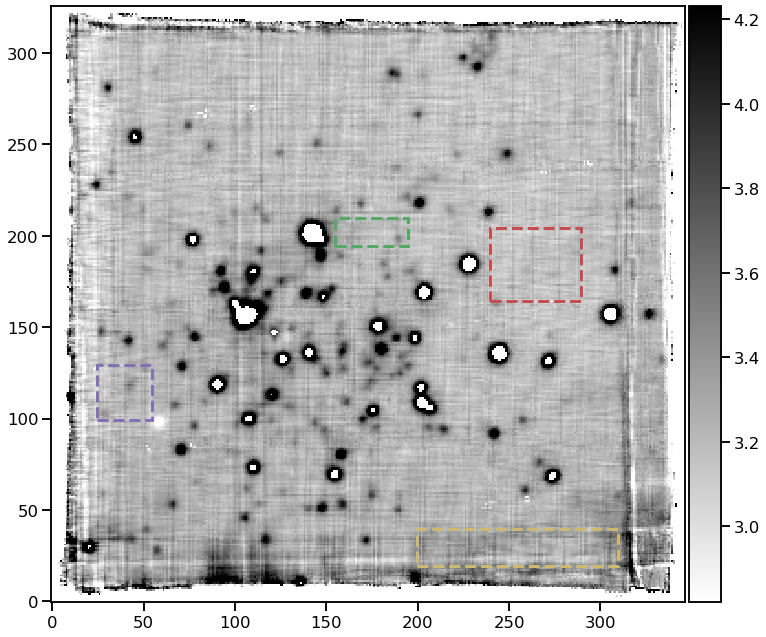

In [24]:
fig, ax = plt.subplots(figsize=(12, 12))
(imha / (imhb)).plot(
    vmin=R0,
    vmax=1.5 * R0,
    scale="linear",
    cmap="gray_r",
    colorbar="v",
)

for box, c in zip(boxes.values(), "yrmgc"):
    box.plot(
        ax=ax,
        lw=3,
        edgecolor=c,
        linestyle="dashed",
        #        facecolor=(1.0, 1.0, 1.0, 0.4),
        fill=False,
    )

We can see some very high extinction at in the S filaments.  And some small increase in extinction in the main diagonal filament.  This is probably limited having foreground emission to some extent.

Look at average values in the sample boxes

In [26]:
for label, box in boxes.items():
    yslice, xslice = box.slices
    ha = np.median(imha[yslice, xslice].data.data)
    hb = np.median(imhb[yslice, xslice].data.data)
    print(f"{label}: {ha/hb:.3f}")

sw filament: 3.318
bow shock: 3.156
w filament: 3.226
c filament: 3.224


        Use get_overlap_slices instead. [warnings]
        Use get_overlap_slices instead. [warnings]
        Use get_overlap_slices instead. [warnings]
        Use get_overlap_slices instead. [warnings]


I tried mean and median, and it made very little difference.  Lowest in the bow shock region; slightly higher in the west and central filaments.  Even higher in the southwest filament.

### The reddening law

In [27]:
pn.RedCorr().getLaws()

dict_keys(['No correction', 'CCM89', 'CCM89 Bal07', 'CCM89 oD94', 'S79 H83 CCM89', 'K76', 'SM79 Gal', 'G03 LMC', 'MCC99 FM90 LMC', 'F99-like', 'F99', 'F88 F99 LMC'])

PyNeb does not seem to have anything specifically tailored to the SMC.  The average SMC extinction law is supposedly simply $1/\lambda$.

But, it is possible to get a SMC curve by using the "F99-like" option, which uses the curve of Fitzpatrick & Massa 1990, ApJS, 72, 163. This depends on $R_V$ and 6 other parameters (!!!).  Most of the parameters only affect the UV part of the curve, which does not concern us.

Then, we can use the average values of $R_V$ and the other parameters, which were fit by Gordon:2003l to SMC stars. This is $R_V = 2.74 \pm 0.13$.

So here I compare that SMC curve with $1/\lambda$ and with the Clayton curve for Milky Way (but also adjusted to $R_V = 2.74$):

[(4000.0, 9300.0), (-2.5, 1.0)]

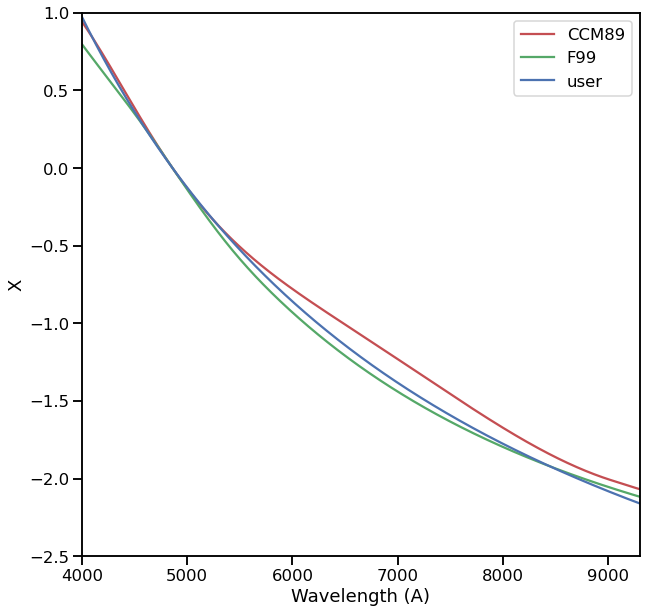

In [28]:
def A_lam(wave):
    return 4861.32 / wave


def my_X(wave, params=[]):
    """A_lam / E(B - V) ~ lam^-1"""
    return A_lam(wave) / (A_lam(4400) - A_lam(5500))


rc = pn.RedCorr()
rc.UserFunction = my_X
rc.R_V = 2.74
rc.FitzParams = [-4.96, 2.26, 0.39, 0.6, 4.6, 1.0]
f, ax = plt.subplots(figsize=(10, 10))
rc.plot(laws=["user", "F99", "CCM89"], ax=ax)

ax.set(
    xlim=[4000, 9300],
    ylim=[-2.5, 1.0],
    #    xlim=[4000, 7000],
    #    ylim=[-1, 1],
)

So the Gordon curve is flatter in the blue, steeper in green, and flatter in red, as compared to $1/\lambda$.

In [29]:
rc = pn.RedCorr()
rc.R_V = 2.74
rc.FitzParams = [-4.96, 2.26, 0.39, 0.6, 4.6, 1.0]
rc.law = "F99"

Test it out for the bow shock region:

In [30]:
rc.setCorr(obs_over_theo=3.123 / R0, wave1=6563.0, wave2=4861.0)
rc.E_BV, rc.cHbeta

(array(0.08918852), 0.11614443544515392)

And for the highest extinction region

In [31]:
rc.setCorr(obs_over_theo=4.165 / R0, wave1=6563.0, wave2=4861.0)
rc.E_BV, rc.cHbeta

(array(0.3412549), 0.44439418598965574)

So $E(B - V)$ varies from about 0.1 to about 0.35. This is similar to what is found for the stars.

### The reddening map

We can now make a map of $E(B - V)$

In [32]:
R = imha / (imhb)
rc.setCorr(obs_over_theo=R.data / R0, wave1=6563.0, wave2=4861.0)
imEBV = R.copy()
imEBV.data = rc.E_BV
imEBV.mask = imha.mask | imhb.mask

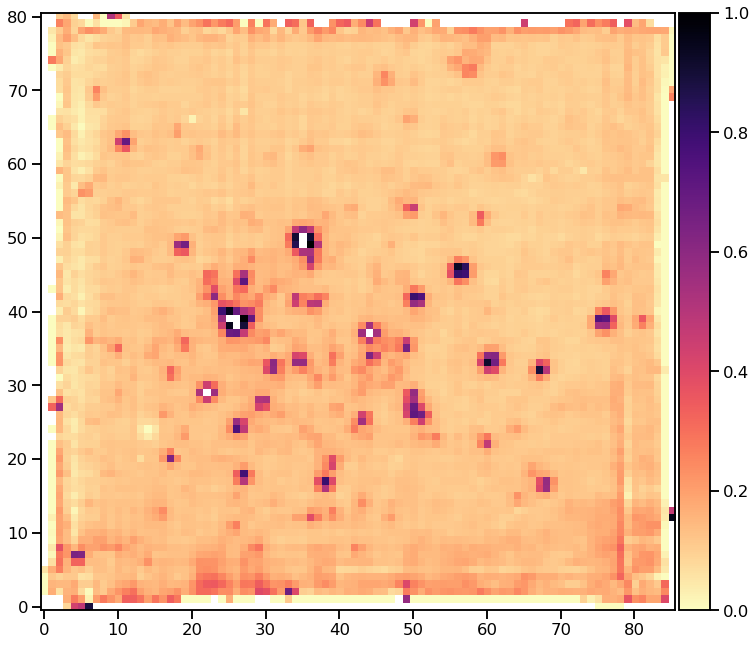

In [34]:
fig, ax = plt.subplots(figsize=(12, 12))
imEBV.rebin(4).plot(
    vmin=0.0,
    vmax=1.0,
    scale="linear",
    cmap="magma_r",
    colorbar="v",
)

Looks like I would expect. Check values in the boxes:

In [35]:
for label, box in boxes.items():
    yslice, xslice = box.slices
    ebv = np.median(imEBV[yslice, xslice].data.data)
    print(f"{label}: {ebv:.3f}")

sw filament: 0.146
bow shock: 0.097
w filament: 0.114
c filament: 0.116


        Use get_overlap_slices instead. [warnings]
        Use get_overlap_slices instead. [warnings]
        Use get_overlap_slices instead. [warnings]
        Use get_overlap_slices instead. [warnings]


These seem the same as before.  But we want to eliminate extreme values.

In [36]:
badpix = (imEBV.data > 1.0) | (imEBV.data < 0.0)
imEBV.mask = imEBV.mask | badpix

Save it to a file:

In [37]:
imEBV.write(str(ROOT / "data/ngc346-PZ-reddening-E_BV.fits"), savemask="nan")

Lots of regions are affected by the stellar absorption.  There are apparent increases in reddening at the position of each star.  This is not real, but is due to the photospheric absorption having more of an effect on Hb (mainly because the emission line is weaker).

At some point, I am going to have to deal with that. But it is not an issue for the bow shock emission, since this is in an area free of stars.  We should just use the median bow shock reddening of $E(B-V) = 0.097$ so that we don't introduce any extra noise.

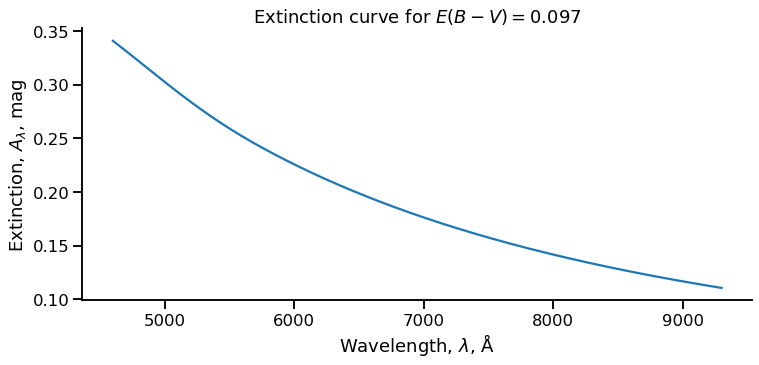

In [38]:
rc.E_BV = 0.097
wavs = np.arange(4600, 9300)
Alam = rc.E_BV * rc.X(wavs)

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(wavs, Alam)
ax.set(
    xlabel="Wavelength, $\lambda$, Å",
    ylabel="Extinction, $A_\lambda$, mag",
    title=f"Extinction curve for $E(B - V) = {rc.E_BV:.3f}$",
)
sns.despine()

## Calculate the [S III] temperature

In [39]:
im6312 = Image(str(ROOT / "data/ngc346-PZ-siii-6312-bin01-sum.fits"))
im9069 = Image(str(ROOT / "data/ngc346-PZ-siii-9069-bin01-sum.fits"))
cont6312 = Image(str(ROOT / "data/ngc346-PZ-cont-6312-mean.fits"))

The raw ratio:

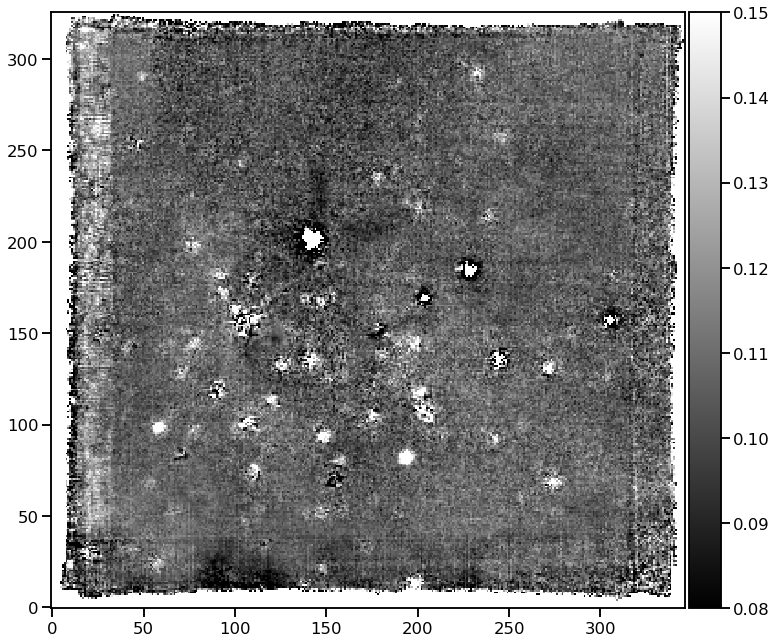

In [44]:
fig, ax = plt.subplots(figsize=(12, 12))
(im6312 / im9069).plot(vmin=0.08, vmax=0.15, cmap="gray", colorbar="v")

That does not look too bad. But we will look at the joint distro anyway.

In [45]:
imax = 15000
slope = 0.1
m = im9069.data < imax
m = m & (im9069.data > -100)
m = m & (im6312.data < slope * imax)
m = m & ~im9069.mask & ~im6312.mask
df = pd.DataFrame(
    {
        "9069": im9069.data[m],
        "6312": im6312.data[m],
    }
)

Text(0.5, 0.98, 'Correlation between [S III] 9069 and 6312 brightness')

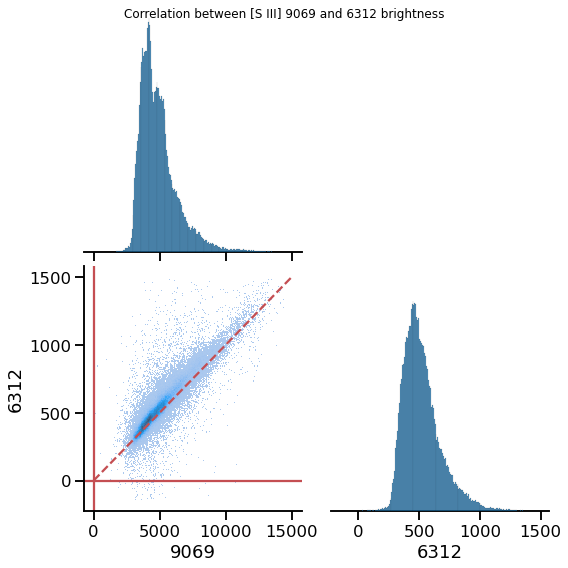

In [46]:
g = sns.pairplot(
    df,
    kind="hist",
    height=4,
    corner=True,
)

g.axes[1, 0].axvline(0.0, color="r")
g.axes[1, 0].axhline(0.0, color="r")
g.axes[1, 0].plot([0, imax], [0, slope * imax], "--", color="r")
g.fig.suptitle("Correlation between [S III] 9069 and 6312 brightness")

Nothing needs to get added to anything. 

In [49]:
imax = 5000
slope = 0.1
x = im9069.data
y = im6312.data
m = x < imax
m = m & (x > -100)
m = m & (y < 1.2 * slope * imax)
m = m & ~im9069.mask & ~im6312.mask
df = pd.DataFrame(
    {
        "9069": x[m],
        "6312": y[m],
    }
)

Text(0.5, 0.98, 'ZOOMED Correlation between [S III] 9069 and 6312 brightness')

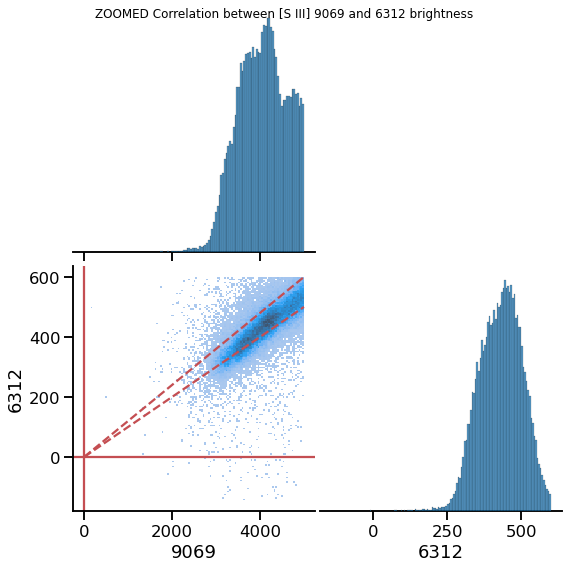

In [51]:
g = sns.pairplot(
    df,
    kind="hist",
    height=4,
    corner=True,
)

g.axes[1, 0].axvline(0.0, color="r")
g.axes[1, 0].axhline(0.0, color="r")
g.axes[1, 0].plot([0, imax], [0, slope * imax], "--", color="r")
g.axes[1, 0].plot([0, imax], [0, 1.2 * slope * imax], "--", color="r")
g.fig.suptitle("ZOOMED Correlation between [S III] 9069 and 6312 brightness")

Now we need to correct for reddening.

In [52]:
A9069 = rc.X(9069) * imEBV
im9069c = im9069.copy()
im9069c.data = im9069.data * 10 ** (0.4 * A9069.data)

In [53]:
A6312 = rc.X(6312) * imEBV
im6312c = im6312.copy()
im6312c.data = (im6312.data) * 10 ** (0.4 * A6312.data)

/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/mpdaf/obj/arithmetic.py:124: RuntimeWarning: invalid value encountered in true_divide
  var /= (b_data ** 4)


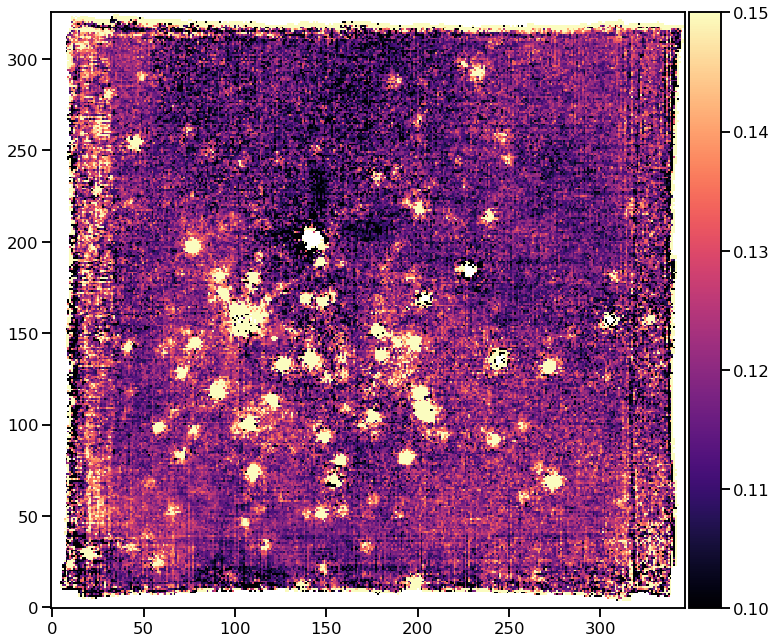

In [55]:
n = 1
fig, ax = plt.subplots(figsize=(12, 12))
(im6312c.rebin(n) / im9069c.rebin(n)).plot(
    vmin=0.1, vmax=0.15, cmap="magma", colorbar="v"
)

<ipython-input-57-1c89ee002e54>:2: RuntimeWarning: divide by zero encountered in log10
  x = np.log10(im9069c.rebin(n).data)
<ipython-input-57-1c89ee002e54>:2: RuntimeWarning: invalid value encountered in log10
  x = np.log10(im9069c.rebin(n).data)
<ipython-input-57-1c89ee002e54>:3: RuntimeWarning: divide by zero encountered in log10
  y = np.log10(im6312c.rebin(n).data / im9069c.rebin(n).data)
<ipython-input-57-1c89ee002e54>:3: RuntimeWarning: invalid value encountered in log10
  y = np.log10(im6312c.rebin(n).data / im9069c.rebin(n).data)


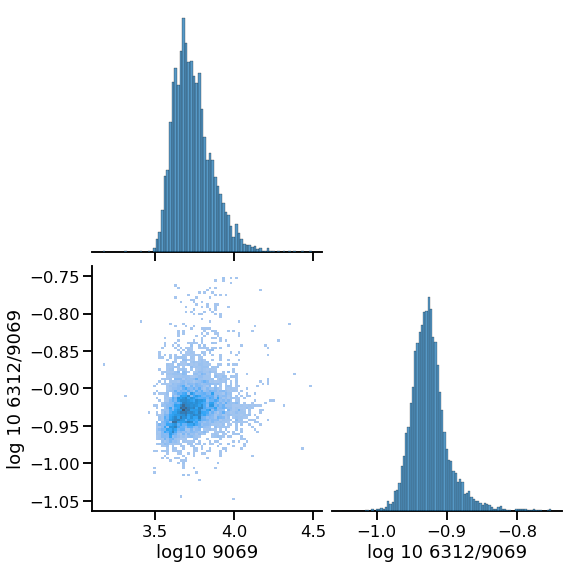

In [57]:
n = 4
x = np.log10(im9069c.rebin(n).data)
y = np.log10(im6312c.rebin(n).data / im9069c.rebin(n).data)
m = (x > 3.0) & (x < 4.5)
m = m & (y > -1.05) & (y < -0.75)
m = m & ~im9069c.rebin(n).mask & ~im6312c.rebin(n).mask
df = pd.DataFrame(
    {
        "log10 9069": x[m],
        "log 10 6312/9069": y[m],
    }
)
g = sns.pairplot(
    df,
    kind="hist",
    height=4,
    corner=True,
)

This is totally different from what we got from the ESO cube.  This version is much more reliable, since with the other one we had no idea where the zeropoint was

Now, make a mask of EW(6312).  But first, we need to correct the zero point of the continuum.

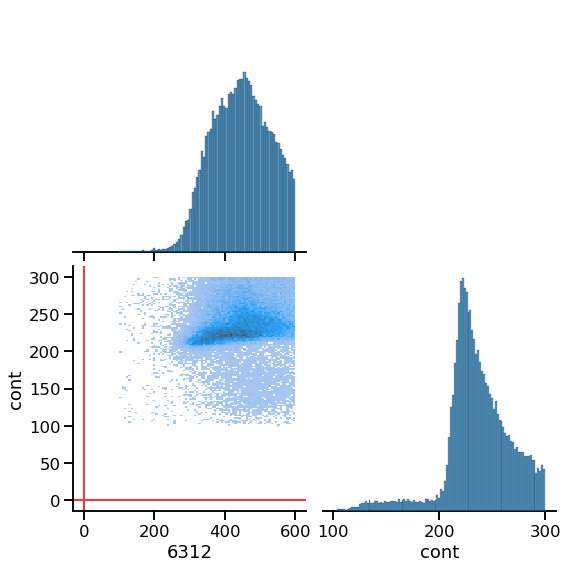

In [64]:
im6312_zero = 0.0
cont6312_zero = 0.0
imax = 600
x = im6312.data - im6312_zero
y = cont6312.data - cont6312_zero
m = x < imax
m = m & (x > 100)
m = m & (y < 300) & (y > 100)
m = m & ~cont6312.mask & ~im6312.mask
df = pd.DataFrame(
    {
        "6312": x[m],
        "cont": y[m],
    }
)
g = sns.pairplot(
    df,
    kind="hist",
    height=4,
    corner=True,
)

g.axes[1, 0].axvline(0.0, color="r")
g.axes[1, 0].axhline(0.0, color="r")

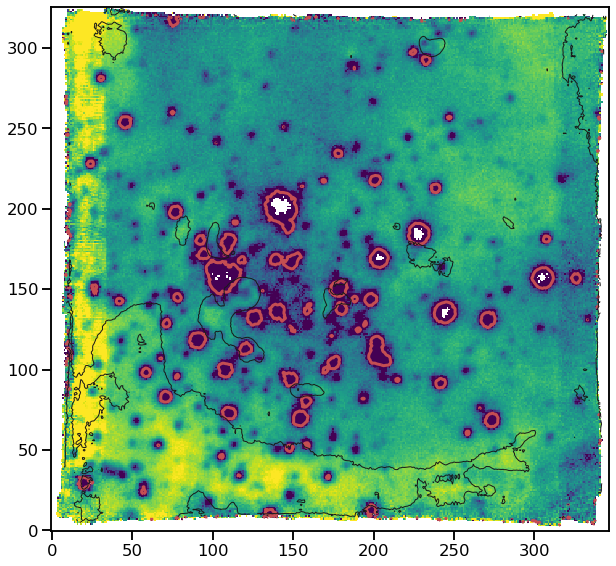

In [71]:
fig, ax = plt.subplots(figsize=(10, 10))
ew6312 = 1.25 * (im6312 - im6312_zero) / (cont6312 - cont6312_zero)
ew6312.plot(vmin=1.0, vmax=5.0, scale="sqrt")
ax.contour(ew6312.data, levels=[0.5], colors="r", linewidths=3)
ax.contour(im9069.data, levels=[6000.0], colors="k", linewidths=1)

In [72]:
fixmask = (ew6312.data < 1.0) | (im9069.data < 3000.0)
fixmask = fixmask & (im6312c.data < 0.1 * im9069c.data)
fixmask = fixmask & (im6312c.data > 0.2 * im9069c.data)
iborder = 12
fixmask[:iborder, :] = True
fixmask[-iborder:, :] = True
fixmask[:, :iborder] = True
fixmask[:, -iborder:] = True

In [73]:
im6312c.mask = im6312c.mask | fixmask

/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/mpdaf/obj/arithmetic.py:124: RuntimeWarning: invalid value encountered in true_divide
  var /= (b_data ** 4)


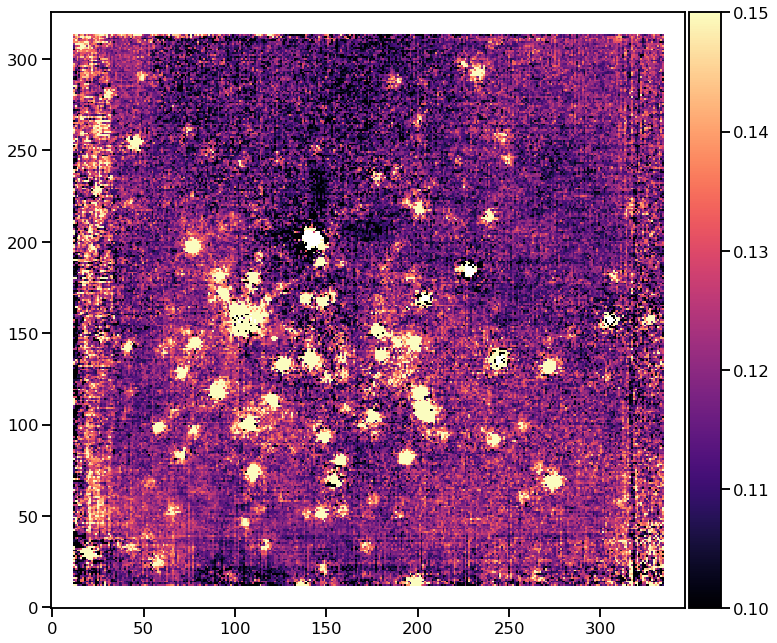

In [75]:
n = 1
fig, ax = plt.subplots(figsize=(12, 12))
(im6312c.rebin(n) / im9069c.rebin(n)).plot(
    vmin=0.1, vmax=0.15, cmap="magma", colorbar="v"
)

Honestly, this looks identical to the last one. So I do not know what I am even doing here. 

<ipython-input-76-50983f2f0a69>:2: RuntimeWarning: divide by zero encountered in log10
  x = np.log10(im9069c.rebin(n).data)
<ipython-input-76-50983f2f0a69>:2: RuntimeWarning: invalid value encountered in log10
  x = np.log10(im9069c.rebin(n).data)
<ipython-input-76-50983f2f0a69>:3: RuntimeWarning: divide by zero encountered in log10
  y = np.log10(im6312c.rebin(n).data / im9069c.rebin(n).data)
<ipython-input-76-50983f2f0a69>:3: RuntimeWarning: invalid value encountered in log10
  y = np.log10(im6312c.rebin(n).data / im9069c.rebin(n).data)


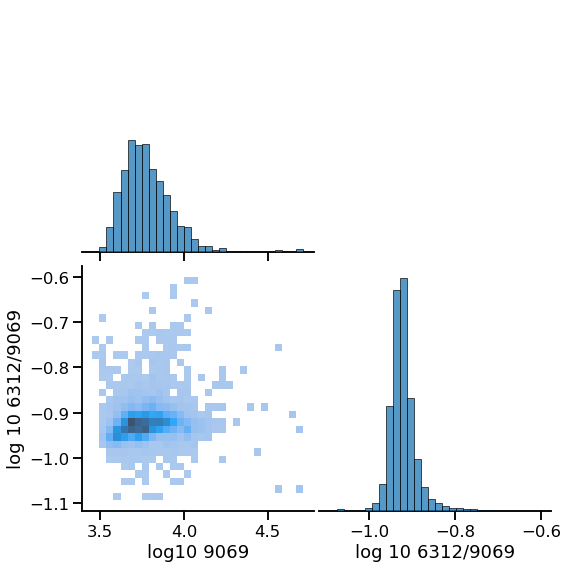

In [76]:
n = 4
x = np.log10(im9069c.rebin(n).data)
y = np.log10(im6312c.rebin(n).data / im9069c.rebin(n).data)
z = im9069c.rebin(n).data
m = (x > 2.5) & (x < 5.5)
m = m & (y > -1.1) & (y < -0.6)
m = m & ~im9069c.rebin(n).mask & ~im6312c.rebin(n).mask
df = pd.DataFrame(
    {
        "log10 9069": x[m],
        "log 10 6312/9069": y[m],
    }
)
kws = dict(weights=z[m], bins=30)
g = sns.pairplot(
    df,
    kind="hist",
    height=4,
    corner=True,
    plot_kws=kws,
    diag_kws=kws,
)

### Convert to actual temperatures with pyneb

In [77]:
s3 = pn.Atom("S", 3)

In [78]:
s3.getTemDen([0.1, 0.2], den=100.0, wave1=6300, wave2=9069)

array([12128.90515246, 19243.6434518 ])

In [79]:
r_s3_grid = np.linspace(0.05, 0.25, 201)
T_s3_grid = s3.getTemDen(r_s3_grid, den=100.0, wave1=6300, wave2=9069)

In [80]:
imT_siii = im6312c.clone(data_init=np.empty)
imT_siii.data[~fixmask] = np.interp(
    im6312c.data[~fixmask] / im9069c.data[~fixmask],
    r_s3_grid,
    T_s3_grid,
    left=np.nan,
    right=np.nan,
)
# imT_siii.mask = imT_siii.mask | fixmask
# imT_siii.data[imT_siii.mask] = np.nan

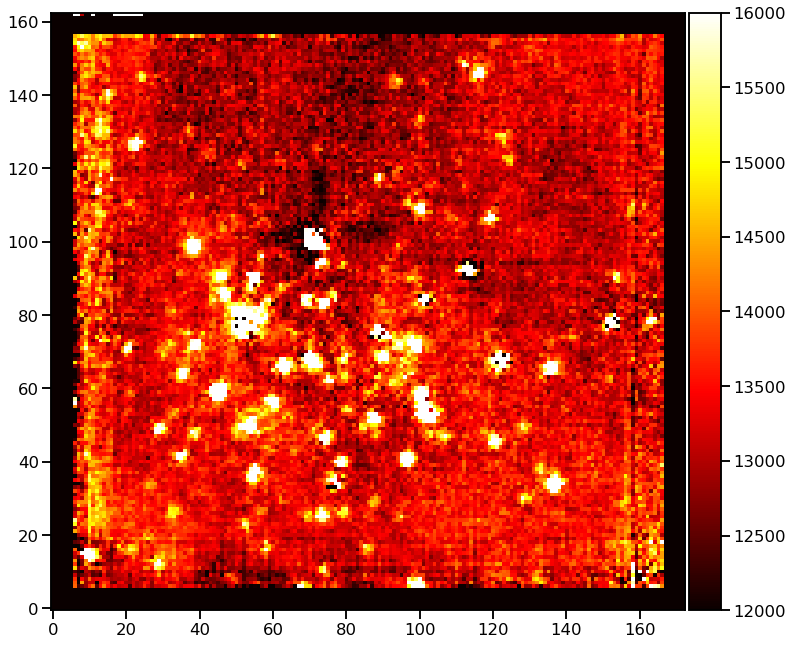

In [86]:
fig, ax = plt.subplots(figsize=(12, 12))
imT_siii.rebin(2).plot(colorbar="v", cmap="hot", vmin=12000, vmax=16000)

In [84]:
badpix = ~np.isfinite(imT_siii.data)
imT_siii.mask = imT_siii.mask | badpix

In [85]:
imT_siii.write(str(ROOT / "data/ngc346-PZ-T-siii.fits"), savemask="nan")

The rather disappointing conclusion of this is that the [S III] temperatures do vary from about 13 to 16 kK, but they don't show anything special at the bow shock, being about 13.7 +/- 0.4 kK there.

If anything, the T is lower in the bow shock.

Average over whole FOV is 14.2 +/- 0.8 kK after smoothing to eliminate the noise contribution.  This implies $t^2 = 0.003$ in plane of sky, which is small.

## Calculate [O III]/[S III]

In [87]:
im5007 = Image(str(ROOT / "data/ngc346-PZ-oiii-5007-bin01-sum.fits"))

Correct for extinction:

In [88]:
A5007 = rc.X(5007) * imEBV
im5007c = im5007.copy()
im5007c.data = im5007.data * 10 ** (0.4 * A5007.data)

In [89]:
median_EBV = np.median(imEBV[150:250, 200:300].data)
median_EBV

/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


0.10234727500966831

In [90]:
im5007cc = im5007.copy()
im5007cc.data = im5007.data * 10 ** (0.4 * rc.X(5007) * median_EBV)
im9069cc = im9069.copy()
im9069cc.data = im9069.data * 10 ** (0.4 * rc.X(9069) * median_EBV)

Quick look:

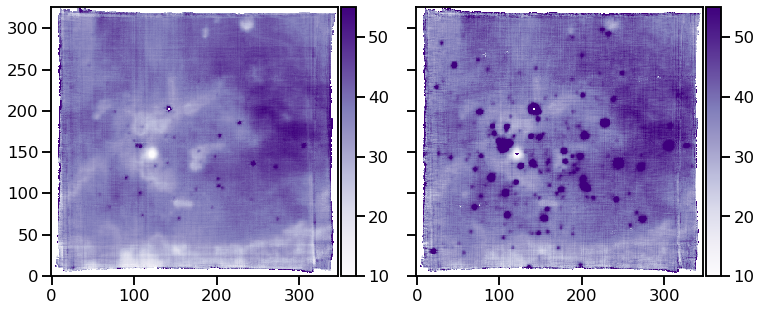

In [102]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(12, 6))
((im5007cc) / im9069cc).plot(
    vmin=10,
    vmax=55,
    colorbar="v",
    scale="linear",
    cmap="Purples",
    ax=axes[0],
)
((im5007c) / im9069c).plot(
    vmin=10,
    vmax=55,
    colorbar="v",
    scale="linear",
    cmap="Purples",
    ax=axes[1],
)

The left panel is with a median reddening. The right panel is with a pixel-by-pixel reddening but that fails at the position of stars. 

Check zero points:

Text(0.5, 0.98, 'Correlation between [S III] 9069 and [O III] 5007 brightness')

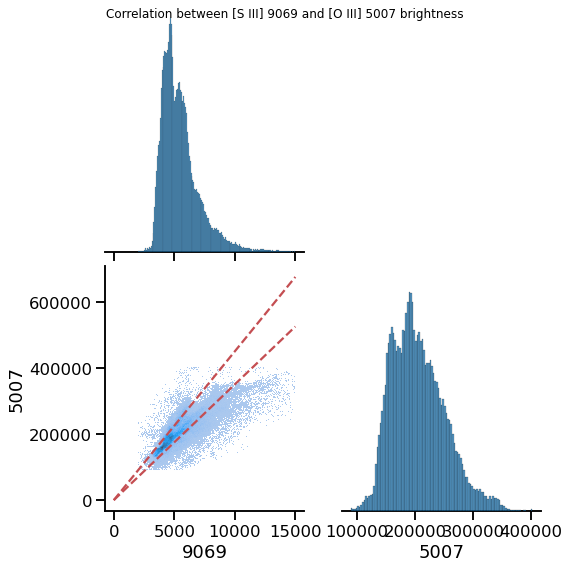

In [106]:
imax = 15000
imin = 2000
slope = 45
slope2 = 35
x = im9069cc.data
y = im5007cc.data
m = x < imax
m = m & (x > imin)
m = m & (y < slope * imax)
m = m & (y > slope * imin)
m = m & ~im9069c.mask & ~im5007c.mask
df = pd.DataFrame(
    {
        "9069": x[m],
        "5007": y[m],
    }
)
g = sns.pairplot(
    df,
    kind="hist",
    height=4,
    corner=True,
)
# g.axes[1, 0].axvline(0.0, color="r")
# g.axes[1, 0].axhline(0.0, color="r")
g.axes[1, 0].plot([0, imax], [0, slope * imax], "--", color="r")
g.axes[1, 0].plot([0, imax], [0, slope2 * imax], "--", color="r")
g.fig.suptitle("Correlation between [S III] 9069 and [O III] 5007 brightness")

Text(0.5, 0.98, 'Correlation between [S III] 9069 and [O III] / [S III] ratio')

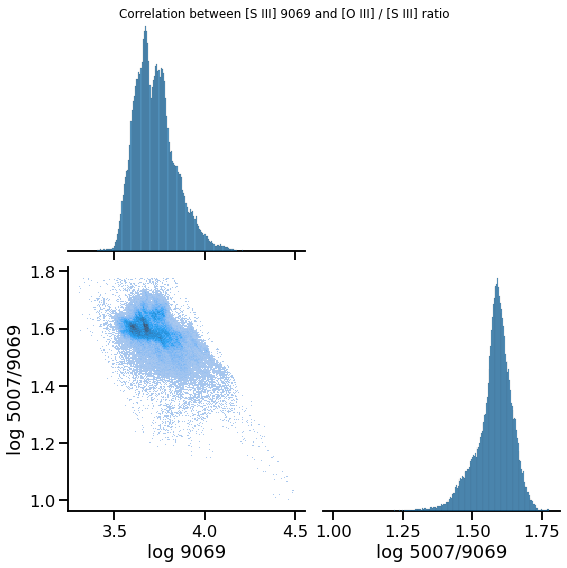

In [108]:
slope = 45
slope2 = 35
x = im9069cc.data
y = im5007cc.data
m = x > imin
m = m & (y > 10 * x) & (y < 60 * x)
m = m & ~im9069cc.mask & ~im5007cc.mask
df = pd.DataFrame(
    {
        "log 9069": np.log10(x[m]),
        "log 5007/9069": np.log10(y[m] / x[m]),
    }
)
g = sns.pairplot(
    df,
    kind="hist",
    height=4,
    corner=True,
)
g.fig.suptitle("Correlation between [S III] 9069 and [O III] / [S III] ratio")

In [110]:
imR_oiii_siii = (im5007cc) / im9069cc
imR_oiii_siii.write(
    str(ROOT / "data/ngc346-PZ-R-oiii-5007-siii-9069.fits"), savemask="nan"
)

## Calculate [O III] / Hβ

This might be better since at least it is not affected by reddening.

Text(0.5, 0.98, 'Correlation between Hβ 4861 and [O III] 5007 brightness')

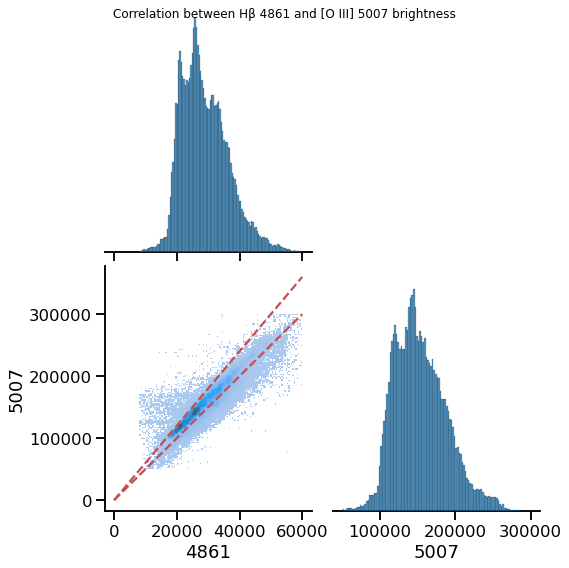

In [113]:
imax = 60000
imin = 2000
slope = 5.0
slope2 = 6.0
x = imhb.data
y = im5007.data
m = x < imax
m = m & (x > imin)
m = m & (y < slope * imax)
m = m & (y > slope * imin)
m = m & ~imhb.mask & ~im5007.mask
df = pd.DataFrame(
    {
        "4861": x[m],
        "5007": y[m],
    }
)
g = sns.pairplot(
    df,
    kind="hist",
    height=4,
    corner=True,
)
g.axes[1, 0].plot([0, imax], [0, slope * imax], "--", color="r")
g.axes[1, 0].plot([0, imax], [0, slope2 * imax], "--", color="r")
g.fig.suptitle("Correlation between Hβ 4861 and [O III] 5007 brightness")

Text(0.5, 0.98, 'Correlation between Hβ 4861 and [O III] / Hβ ratio')

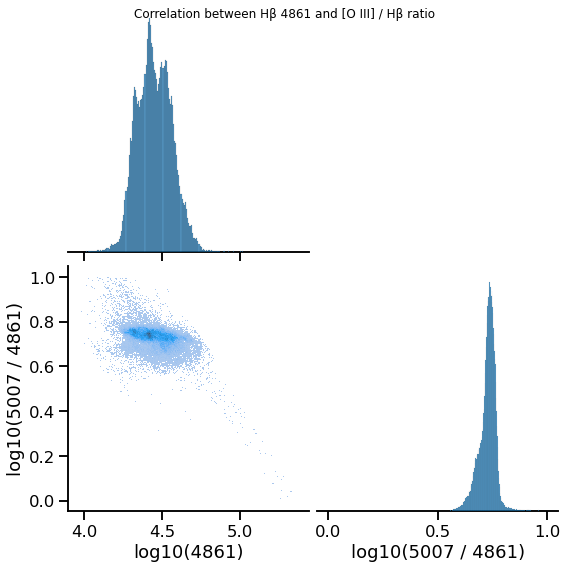

In [114]:
n = 1
x = imhb.rebin(n).data
y = im5007.rebin(n).data
m = (x > imin) & (y > x) & (y < 10 * x)
m = m & ~imhb.rebin(n).mask & ~im5007.rebin(n).mask
df = pd.DataFrame(
    {
        "log10(4861)": np.log10(x[m]),
        "log10(5007 / 4861)": np.log10(y[m] / x[m]),
    }
)
g = sns.pairplot(
    df,
    kind="hist",
    height=4,
    corner=True,
)
g.fig.suptitle("Correlation between Hβ 4861 and [O III] / Hβ ratio")

In [115]:
imR_oiii_hb = (im5007) / (imhb)
imR_oiii_hb.write(str(ROOT / "data/ngc346-PZ-R-oiii-5007-hi-4861.fits"), savemask="nan")

In [123]:
im4740 = Image(str(ROOT / "data/ngc346-PZ-ariv-4740-bin01-sum.fits"))

In [124]:
from astropy.convolution import convolve_fft
from astropy.convolution import Gaussian2DKernel

In [130]:
im = convolve_fft(im4740.data, Gaussian2DKernel(5.0))

Text(0.5, 1.0, '[O III] / Hβ')

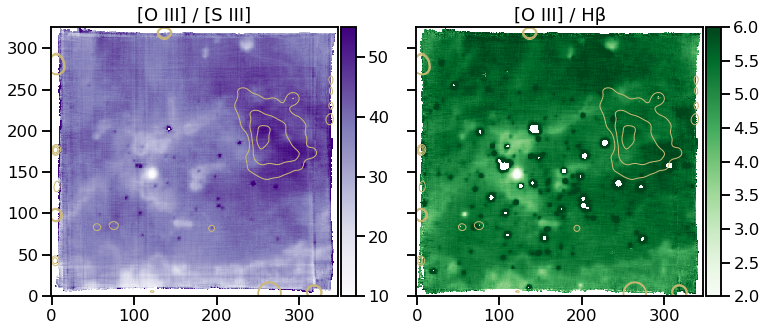

In [133]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(12, 6))
imR_oiii_siii.plot(
    vmin=10,
    vmax=55,
    colorbar="v",
    scale="linear",
    ax=axes[0],
    cmap="Purples",
)
imR_oiii_hb.plot(
    vmin=2,
    vmax=6,
    colorbar="v",
    scale="linear",
    ax=axes[1],
    cmap="Greens",
)
for ax in axes:
    ax.contour(im, levels=[200, 250, 300], linewidths=1, colors="y")
axes[0].set_title("[O III] / [S III]")
axes[1].set_title("[O III] / Hβ")

So, the bow shock shows up much better in [O III]/[S III] than it does in [O III]/Hb.  This implies that it must be a lack of [S III], rather than an excess of [O III] that characterises the bow shock.

## Calculate He I / Hβ

Let us see if this has a hole in it where the He II is coming from.

In [ ]:
im5875 = Image(str(ROOT / "data/ngc346-hei-5875-bin01-sum.fits"))
im4922 = Image(str(ROOT / "data/ngc346-hei-4922-bin01-sum.fits"))
im5048 = Image(str(ROOT / "data/ngc346-hei-5048-bin01-sum.fits"))

In [ ]:
fig, axes = plt.subplots(2, 2, sharey=True, figsize=(12, 12))
im5875.plot(ax=axes[0, 0], vmin=0, vmax=5000)
im4922.plot(ax=axes[0, 1], vmin=0, vmax=300)
(imhb - hbfix).plot(ax=axes[1, 0], vmin=0, vmax=40000)
im5048.plot(ax=axes[1, 1], vmin=0, vmax=50)
axes[0, 0].set_title("He I 5875")
axes[0, 1].set_title("He I 4922")
axes[1, 0].set_title("H I 4861")
axes[1, 1].set_title("He I 5048")

So 5875 is 10 to 100 times brighter than the other two. And it is almost identical to Hβ!

In [ ]:
imax = 10000
slope = 0.12
x = imhb.data - hbfix
y = im5875.data
m = x < imax
m = m & (x > -100)
m = m & (y < slope * imax)
m = m & (y > -100 * slope)
m = m & ~imhb.mask & ~im5875.mask
df = pd.DataFrame(
    {
        "4861": x[m],
        "5875": y[m],
    }
)
g = sns.pairplot(
    df,
    kind="hist",
    height=4,
    corner=True,
    plot_kws=dict(weights=x[m], bins=200),
    diag_kws=dict(weights=x[m], bins=200),
)
g.axes[1, 0].axvline(0.0, color="r")
g.axes[1, 0].axhline(0.0, color="r")
g.axes[1, 0].plot([0, imax], [0, slope * imax], "--", color="r")
g.fig.suptitle("Correlation between Hβ 4861 and He I 5875 brightness")

In [ ]:
imax = 100000
slope = 0.12
x = imhb.data - hbfix
y = im5875.data
m = x < imax
m = m & (x > -100)
m = m & (y < slope * imax)
m = m & (y > -100 * slope)
m = m & ~imhb.mask & ~im5875.mask
df = pd.DataFrame(
    {
        "4861": x[m],
        "5875": y[m],
    }
)
g = sns.pairplot(
    df,
    kind="hist",
    height=4,
    corner=True,
    plot_kws=dict(weights=x[m], bins=200),
    diag_kws=dict(weights=x[m], bins=200),
)
g.axes[1, 0].axvline(0.0, color="r")
g.axes[1, 0].axhline(0.0, color="r")
g.axes[1, 0].plot([0, imax], [0, slope * imax], "--", color="r")
g.fig.suptitle("Correlation between Hβ 4861 and He I 5875 brightness")

In [ ]:
imR_hei_hb = im5875 / (imhb - hbfix)

In [ ]:
fig, ax = plt.subplots(figsize=(12, 12))
imR_hei_hb.plot(colorbar="v", cmap="gray", vmin=0.11, vmax=0.14)

In [ ]:
red_R_hei_hb = imR_hei_hb.copy()
red_R_hei_hb.data = 10 ** (0.4 * imEBV.data * (rc.X(4861) - rc.X(5875)))

In [ ]:
fig, ax = plt.subplots(figsize=(12, 12))
(imR_hei_hb / red_R_hei_hb).plot(colorbar="v", cmap="gray", vmin=0.1, vmax=0.115)

So if we correct it for reddening, then lots of spurious structure disappears.  But we are left with very little variation at all, except for at the mYSO and the top right corner, which both show low He I.

## Calculate He II / Hβ



In [ ]:
im4686 = Image(str(ROOT / "data/ngc346-heii-4686-bin01-sum.fits"))

In [ ]:
fig, ax = plt.subplots(figsize=(12, 12))
im4686.plot(colorbar="v", cmap="gray", vmin=0.0, vmax=300)

In [ ]:
imR_heii_hb = im4686 / (imhb - hbfix)

fig, ax = plt.subplots(figsize=(12, 12))
imR_heii_hb.plot(colorbar="v", cmap="gray", vmin=0.0, vmax=0.02)

In [ ]:
n = 2
xslice, yslice = slice(200, 300), slice(100, 250)
x = imR_heii_hb[yslice, xslice].rebin(n).data
y = (
    imR_hei_hb[yslice, xslice].rebin(n).data
    / red_R_hei_hb[yslice, xslice].rebin(n).data
)
z = im4686[yslice, xslice].rebin(n).data
m = x < 0.03
m = m & (x > 0)
m = m & (y < 0.113)
m = m & (y > 0.103)
m = (
    m
    & ~imR_heii_hb[yslice, xslice].rebin(n).mask
    & ~imR_hei_hb[yslice, xslice].rebin(n).mask
)
df = pd.DataFrame(
    {
        "4686 / 4861": x[m],
        "5875 / 4861": y[m],
    }
)
g = sns.pairplot(
    df,
    kind="hist",
    height=4,
    corner=True,
    plot_kws=dict(weights=z[m], bins=30),
    diag_kws=dict(weights=z[m], bins=30),
)
g.fig.suptitle("Correlation between He II / Hβ and He I / Hβ ratios")

So there is a *tiny* change in 5875/4861 from 0.109 to 0.107 as 4686/4861 increases.

In [ ]:
df["high"] = df["4686 / 4861"] > 0.003
df

In [ ]:
sns.histplot(
    data=df,
    x="5875 / 4861",
    hue="high",
    multiple="stack",
    shrink=1.0,
    stat="probability",
    common_norm=False,
    bins=10,
)

## Ratio of [Ar IV] / [Ar III]

In [ ]:
im4711 = Image(str(ROOT / "data/ngc346-ariv-4711-bin01-sum.fits"))
im4740 = Image(str(ROOT / "data/ngc346-ariv-4740-bin01-sum.fits"))
im7171 = Image(str(ROOT / "data/ngc346-ariv-7171-bin01-sum.fits"))
im7237 = Image(str(ROOT / "data/ngc346-ariv-7237-bin01-sum.fits"))
im7263 = Image(str(ROOT / "data/ngc346-ariv-7263-bin01-sum.fits"))
im7136 = Image(str(ROOT / "data/ngc346-ariii-7136-bin01-sum.fits"))

In [ ]:
fig, axes = plt.subplots(2, 2, sharey=True, figsize=(12, 12))
im4711.plot(ax=axes[0, 0], vmin=0, vmax=400)
im4740.plot(ax=axes[0, 1], vmin=0, vmax=250)
(im7171 + im7263).plot(ax=axes[1, 0], vmin=0, vmax=30)
im7136.plot(ax=axes[1, 1], vmin=0, vmax=3500)
axes[0, 0].set_title("[Ar IV] 4711 + He I 4713")
axes[0, 1].set_title("[Ar IV] 4740")
axes[1, 0].set_title("[Ar IV] 7171 + 7263")
axes[1, 1].set_title("[Ar III] 7136")

In [ ]:
n = 8
fig, axes = plt.subplots(2, 2, sharey=True, figsize=(12, 12))
(im4711.rebin(n) / im4740.rebin(n)).plot(ax=axes[0, 0], vmin=0, vmax=4)
(im4740.rebin(n) / im7136.rebin(n)).plot(ax=axes[0, 1], vmin=0, vmax=0.15)
((im7171.rebin(n) + im7263.rebin(n)) / (im4740.rebin(n) + im4711.rebin(n))).plot(
    ax=axes[1, 0], vmin=0, vmax=0.08
)
im7136.rebin(n).plot(ax=axes[1, 1], vmin=0, vmax=3500)
axes[0, 0].set_title("([Ar IV] 4711 + He I 4713) / [Ar IV] 4740")
axes[0, 1].set_title("[Ar IV] 4740 / [Ar III] 7136")
axes[1, 0].set_title("[Ar IV] (7171 + 7263) / (4711 + 4740)")
axes[1, 1].set_title("[Ar III] 7136")

Now we must subtract the He I line!

In [ ]:
hei = pn.RecAtom("He", 1)

In [ ]:
dens = [50, 100, 200]
tems = [13000, 18000]
e4713 = hei.getEmissivity(tems, dens, wave=4713)
e5876 = hei.getEmissivity(tems, dens, wave=5876)
e4713 / e5876

There is a slight temperature dependence, but almost no density dependence if we use the 5876 line.  This is probably the best because it has good signal to noise.

We can assume that the He I temperature is the same as the [S III] temperature.

But we will check the other lines as well.

In [ ]:
e4922 = hei.getEmissivity(tems, dens, wave=4922)
e5048 = hei.getEmissivity(tems, dens, wave=5048)
e4713 / e4922, e4713 / e5048

The 4922 has the same T-dependence as 5876, just 10 times weaker. The 5048 has a constant ratio, but it is so weak that we cannot use it.  So 5876 it is ...

### Average values of T and reddening to use in the corrections

We would introduce too much noise by using the pixel-by-pixel values of $T$ and $E(B - V)$, so we will construct an average value by using the He I brightenss as a weight, but masking out the mYSO


In [ ]:
def trim_edges(im, m):
    """Trim m pixels of each edge of image in place by setting mask"""
    im.mask[:m, :] = True
    im.mask[-m:, :] = True
    im.mask[:, :m] = True
    im.mask[:, -m:] = True
    return None

In [ ]:
im_hei_weight = im5875.copy()
im_hei_weight.mask[140:157, 110:141] = True
im_hei_weight.mask[94:104, 55:65] = True
trim_edges(im_hei_weight, 10)
im_hei_weight.data.mask = im_hei_weight.mask
fig, ax = plt.subplots(figsize=(10, 10))
im_hei_weight.plot(cmap="gray_r")
ax.set_title("Weight mask for He I emission")

That looks OK. Now calculate some averages:

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
im1 = im_hei_weight.copy()
im1.data = im_hei_weight.data * imEBV.data
im1.mask = im_hei_weight.mask | imEBV.mask
im1.plot(ax=axes[0])
im2 = im_hei_weight.copy()
im2.data = im_hei_weight.data * imT_siii.data
im2.mask = im_hei_weight.mask | imT_siii.mask
im2.plot(ax=axes[1])

In [ ]:
avHe_EBV = np.average(imEBV.data, weights=im_hei_weight.data)
avHe_Tsiii = np.average(imT_siii.data, weights=im_hei_weight.data)
f"He I brightness-weighted averages: E(B-V) = {avHe_EBV:.2f}, T = {avHe_Tsiii/1000:.2f} kK"

In [ ]:
median_EBV

The `avHe_Tsiii` looks good. But to be honest, I am a bit suspicious of the `avHe_EBV` reddening, since there are lots of anomalous spots of high $E(B-V)$ that correspond to stars (presumably underlying stellar absorption affecting the Balmer decrement).

I could use the median instead, but I have ended up using the weighted one after all, since we seem to be oversubtracting if anything.

In [ ]:
avHe_reddening_4713_5876 = 10 ** (0.4 * avHe_EBV * (rc.X(4713) - rc.X(5876)))
median_reddening_4713_5876 = 10 ** (0.4 * median_EBV * (rc.X(4713) - rc.X(5876)))
avHe_reddening_4713_5876, median_reddening_4713_5876

In [ ]:
dens = 100.0
avHe_e4713_5876 = hei.getEmissivity(avHe_Tsiii, dens, wave=4713) / hei.getEmissivity(
    avHe_Tsiii, dens, wave=5876
)
avHe_e4713_5876

Take advantage to save extinction-corrected maps of the high-ionization lines.  These are using the avHe reddening, not the pixel-by-pixel values

In [ ]:
avHe_corr_4686 = 10 ** (0.4 * avHe_EBV * rc.X(4686))
avHe_corr_4686

In [ ]:
(im4686 * avHe_corr_4686).write(str(ROOT / "data/ngc346-heii-4686-correct.fits"))

In [ ]:
((imhb - hbfix) * 10 ** (0.4 * avHe_EBV * rc.X(4861))).write(
    str(ROOT / "data/ngc346-hi-4861-correct.fits"),
)
(im5875 * 10 ** (0.4 * avHe_EBV * rc.X(5875))).write(
    str(ROOT / "data/ngc346-hei-5875-correct.fits"),
)
(im7136 * 10 ** (0.4 * avHe_EBV * rc.X(7136))).write(
    str(ROOT / "data/ngc346-ariii-7136-correct.fits"),
)

Now do the correction by faking the 4713 line and subtracting it:

In [ ]:
# im_fake_4713 = (avHe_e4713_5876 / avHe_reddening_4713_5876) * im5875
im_fake_4713 = 0.025 * im5875
im4711c = im4711 - im_fake_4713

Make a common minimal mask to use for all the [Ar IV] lines, which we will then combine with a brightness-based mask for the weaker lines and ratios:

In [ ]:
cont4686 = Image(str(ROOT / "data/ngc346-cont-4686-mean.fits"))

I need to decide how bright a star needs to be before I mask out that bit of the image. 5000 in the `cont4686` image seems a reasonable value.

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
cont4686.plot(colorbar="v", vmin=0, vmax=1e5, scale="sqrt")
ax.contour(cont4686.data, levels=[5e3], colors="r")

In [ ]:
im_ariv_sum = im4711c + im4740
trim_edges(im_ariv_sum, 12)
im_ariv_sum.mask[78:88, 190:199] = True
im_ariv_sum.mask[234:236, 266:271] = True
im_ariv_sum.mask[81:84, 52:55] = True
im_ariv_sum.mask = im_ariv_sum.mask | (cont4686.data > 1.5e3)
im_ariv_sum.mask = im_ariv_sum.mask | (im_ariv_sum.data > 650)
im_ariv_sum.mask = im_ariv_sum.mask | (im_ariv_sum.data < -250)
fig, ax = plt.subplots(figsize=(10, 10))
im_ariv_sum.rebin(1).plot(colorbar="v", vmin=-10, vmax=600, cmap="gray_r", scale="sqrt")

That is looking good.  Apply the mask to all the other images

In [ ]:
for im in im4711c, im4740, im7171, im7263, im7237:
    im.mask = im.mask | im_ariv_sum.mask

Now find average reddening for [Ar IV] lines.  Try two methods: (1) brightness-weighted mean; (2) make a mask based on the Ar IV brightness and then take median in that area.

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
im = im_ariv_sum.copy()
im.data = imEBV.data
im.mask = im.mask | (im_ariv_sum.data < 120)
trim_edges(im, 20)
im.plot(vmin=0, vmax=0.2, cmap="magma_r", colorbar="v")

In [ ]:
avArIV_EBV = np.average(imEBV.data, weights=im_ariv_sum.data)
medianArIV_EBV = np.median(im.data.data[~im.mask])
avArIV_EBV, medianArIV_EBV

So there isn't much difference. But we take the median since it should be less sensitive to those spots of higher $E(B-V)$ due to stars.

Apply extinction correction to all lines:

In [ ]:
im4740r = im4740 * 10 ** (0.4 * medianArIV_EBV * rc.X(4740))
im4711r = im4711c * 10 ** (0.4 * medianArIV_EBV * rc.X(4711))
im7171r = im7171 * 10 ** (0.4 * medianArIV_EBV * rc.X(7171))
im7136r = im7136 * 10 ** (0.4 * medianArIV_EBV * rc.X(7136))
im7263r = im7263 * 10 ** (0.4 * medianArIV_EBV * rc.X(7263))
im7237r = im7237 * 10 ** (0.4 * medianArIV_EBV * rc.X(7237))
for im in im4711r, im4740r, im7171r, im7136r, im7263r, im7237r:
    im.mask = im.mask | im_ariv_sum.mask

And replace the summed image:

In [ ]:
im_ariv_sum = im4711r + im4740r

In [ ]:
ariv_R1 = im4711r / im4740r
ariv_R1.mask = ariv_R1.mask | (im_ariv_sum.data < 300)
ariv_R3_plus_R4 = (im7171r + im7263r) / (im4740r + im4711r)
ariv_R3_plus_R4.mask = ariv_R3_plus_R4.mask | (im_ariv_sum.data < 400)
trim_edges(ariv_R1, 20)
trim_edges(ariv_R3_plus_R4, 20)

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12), sharex="row", sharey="row")
im4711r.plot(ax=axes[0, 0], vmin=-20, vmax=400, colorbar="v", cmap=cmr.bubblegum)
im4740r.plot(ax=axes[0, 1], vmin=-20, vmax=350 / 1.3, colorbar="v", cmap=cmr.bubblegum)
n = 8
# (im4711c.rebin(n) / im4740.rebin(n)).plot(ax=axes[1, 0], vmin=0, vmax=2, colorbar="v")
# (
#    (im7171.rebin(n) + im7263.rebin(n))
#     / (im4740.rebin(n) + im4711c.rebin(n))
# ).plot(ax=axes[1, 1], vmin=0, vmax=0.08, colorbar="v")
ariv_R1.rebin(n).plot(ax=axes[1, 0], vmin=0, vmax=2, cmap="mako_r", colorbar="v")
ariv_R3_plus_R4.rebin(n).plot(
    ax=axes[1, 1], vmin=0, vmax=0.08, cmap="inferno", colorbar="v"
)

Save the combined image, corrected for extinction:

In [ ]:
im_ariv_sum.write(
    str(ROOT / "data/ngc346-ariv-4711-plus-4740-correct.fits"), savemask="nan"
)
im4740r.write(str(ROOT / "data/ngc346-ariv-4740-correct.fits"), savemask="nan")
im4711r.write(str(ROOT / "data/ngc346-ariv-4711-correct.fits"), savemask="nan")
im7171r.write(str(ROOT / "data/ngc346-ariv-7171-correct.fits"), savemask="nan")
im7263r.write(str(ROOT / "data/ngc346-ariv-7263-correct.fits"), savemask="nan")

In [ ]:
n = 4
xslice, yslice = slice(200, 300), slice(100, 250)
ratio = 1.35
xmax = 300
ymax = ratio * xmax
x = im4740r[yslice, xslice].rebin(n).data
y = im4711r[yslice, xslice].rebin(n).data
z = im_ariv_sum[yslice, xslice].rebin(n).data
m = (x > -100.0) & (y > -100.0) & (x < xmax) & (y < ymax)
# m = m & (x > 0)
# m = m & (y < 0.113)
# m = m & (y > 0.103)
m = m & ~im4740r[yslice, xslice].rebin(n).mask & ~im4711r[yslice, xslice].rebin(n).mask
df = pd.DataFrame(
    {
        "4740": x[m],
        "4711": y[m],
    }
)
g = sns.pairplot(
    df,
    kind="hist",
    height=4,
    corner=True,
    plot_kws=dict(
        # weights=z[m],
        bins=64
        // n
    ),
    diag_kws=dict(
        # weights=z[m],
        bins=128
        // n
    ),
)
g.axes[1, 0].plot([0, xmax], [0, ymax])
g.fig.suptitle("Correlation between [Ar IV] 4711 and 4740")

In [ ]:
n = 2
xslice, yslice = slice(200, 300), slice(100, 250)
ratio = 1.35
xmax = 300
ymax = ratio * xmax
x = im4740r[yslice, xslice].rebin(n).data
y = im4711r[yslice, xslice].rebin(n).data
z = im_ariv_sum[yslice, xslice].rebin(n).data
m = (x > -100.0) & (y > -100.0) & (x < xmax) & (y < ymax)
y = y / x
m = m & (y < 2.5 * ratio) & (y > 0.0)
# m = m & (x > 0)
# m = m & (y < 0.113)
# m = m & (y > 0.103)
m = m & ~im4740[yslice, xslice].rebin(n).mask & ~im4711[yslice, xslice].rebin(n).mask
df = pd.DataFrame(
    {
        "4740": x[m],
        "4711 / 4740": y[m],
    }
)
g = sns.pairplot(
    df,
    kind="hist",
    height=4,
    corner=True,
    plot_kws=dict(weights=z[m], bins=200 // n),
    diag_kws=dict(weights=z[m], bins=100 // int(np.sqrt(n))),
)
g.axes[1, 0].axhline(ratio, linestyle="dashed", color="k", linewidth=2)
g.axes[1, 1].axvline(ratio, linestyle="dashed", color="k", linewidth=2)
g.fig.suptitle("Correlation between [Ar IV] 4740 and 4711 / 4740")

In [ ]:
ariv = pn.Atom("Ar", 4)

In [ ]:
ariv.getTemDen([1.30, 1.35, 1.40], tem=17500, wave1=4711, wave2=4740)

So we are close to the low density limit, with a nominal value of 160.  We need to get a very precise estimate of the uncertainty in order to get the error bars.

In [ ]:
ariv.getSources()

Now for the T diagnostics:

In [ ]:
n = 4
xslice, yslice = slice(200, 300), slice(100, 250)
ratio = 0.024
xmax = 750
ymax = ratio * xmax
x = im_ariv_sum[yslice, xslice].rebin(n).data
y = im7171r[yslice, xslice].rebin(n).data
z = im_ariv_sum[yslice, xslice].rebin(n).data
m = (x > -0.5 * xmax) & (y > -2 * ymax) & (x < xmax) & (y < 3 * ymax)
# m = m & (x > 0)
# m = m & (y < 0.113)
# m = m & (y > 0.103)
m = (
    m
    & ~im_ariv_sum[yslice, xslice].rebin(n).mask
    & ~im7171[yslice, xslice].rebin(n).mask
)
df = pd.DataFrame(
    {
        "4711 + 4740": x[m],
        "7171": y[m],
    }
)
g = sns.pairplot(
    df,
    kind="hist",
    height=4,
    corner=True,
    plot_kws=dict(weights=z[m], bins=128 // n),
    diag_kws=dict(weights=200 + z[m], bins=128 // n),
)
g.axes[1, 0].plot([0, xmax], [0, ymax])
g.fig.suptitle("Correlation between [Ar IV] 4711+40 and 7171")

In [ ]:
n = 4
xslice, yslice = slice(200, 300), slice(100, 250)
ratio = 0.024
xmax = 750
ymax = ratio * xmax
x = im_ariv_sum[yslice, xslice].rebin(n).data
y = im7263r[yslice, xslice].rebin(n).data
z = im_ariv_sum[yslice, xslice].rebin(n).data
m = (x > -0.5 * xmax) & (y > -2 * ymax) & (x < xmax) & (y < 3 * ymax)
# m = m & (x > 0)
# m = m & (y < 0.113)
# m = m & (y > 0.103)
m = (
    m
    & ~im_ariv_sum[yslice, xslice].rebin(n).mask
    & ~im7171[yslice, xslice].rebin(n).mask
)
df = pd.DataFrame(
    {
        "4711 + 4740": x[m],
        "7263": y[m],
    }
)
g = sns.pairplot(
    df,
    kind="hist",
    height=4,
    corner=True,
    plot_kws=dict(weights=z[m], bins=128 // n),
    diag_kws=dict(weights=200 + z[m], bins=128 // n),
)
g.axes[1, 0].plot([0, xmax], [0, ymax])
g.fig.suptitle("Correlation between [Ar IV] 4711+40 and 7263")

In [ ]:
n = 4
xslice, yslice = slice(200, 300), slice(100, 250)
ratio = 0.024
xmax = 600
ymax = ratio * xmax
x = im_ariv_sum[yslice, xslice].rebin(n).data
y = im7171r[yslice, xslice].rebin(n).data
z = im_ariv_sum[yslice, xslice].rebin(n).data
m = (x > -0.5 * xmax) & (y > -2 * ymax) & (x < xmax) & (y < 3 * ymax)
y = y / x
m = m & (y > -ratio) & (y < 3 * ratio)
# m = m & (x > 0)
# m = m & (y < 0.113)
# m = m & (y > 0.103)
m = (
    m
    & ~im_ariv_sum[yslice, xslice].rebin(n).mask
    & ~im7171[yslice, xslice].rebin(n).mask
)
df = pd.DataFrame(
    {
        "4711 + 4740": x[m],
        "7171 / (4711 + 4740)": y[m],
    }
)
g = sns.pairplot(
    df,
    kind="hist",
    height=4,
    corner=True,
    plot_kws=dict(weights=z[m], bins=128 // n),
    diag_kws=dict(weights=200 + z[m], bins=128 // n),
)
g.fig.suptitle("Correlation between [Ar IV] 4711+40 and 7171 / (4711 + 4740)")

In [ ]:
n = 4
xslice, yslice = slice(200, 300), slice(100, 250)
ratio = 0.024
xmax = 600
ymax = ratio * xmax
x = im_ariv_sum[yslice, xslice].rebin(n).data
y = im7263r[yslice, xslice].rebin(n).data
z = im_ariv_sum[yslice, xslice].rebin(n).data
m = (x > -0.5 * xmax) & (y > -2 * ymax) & (x < xmax) & (y < 3 * ymax)
y = y / x
m = m & (y > -ratio) & (y < 3 * ratio)
# m = m & (x > 0)
# m = m & (y < 0.113)
# m = m & (y > 0.103)
m = (
    m
    & ~im_ariv_sum[yslice, xslice].rebin(n).mask
    & ~im7263[yslice, xslice].rebin(n).mask
)
df = pd.DataFrame(
    {
        "4711 + 4740": x[m],
        "7263 / (4711 + 4740)": y[m],
    }
)
g = sns.pairplot(
    df,
    kind="hist",
    height=4,
    corner=True,
    plot_kws=dict(weights=z[m], bins=128 // n),
    diag_kws=dict(weights=200 + z[m], bins=128 // n),
)
g.fig.suptitle("Correlation between [Ar IV] 4711+40 and 7263 / (4711 + 4740)")

And do the one that is contaminated by C II

In [ ]:
n = 8
xslice, yslice = slice(200, 300), slice(100, 250)
ratio = 0.024
xmax = 600
ymax = ratio * xmax
x = im_ariv_sum[yslice, xslice].rebin(n).data
y = im7237r[yslice, xslice].rebin(n).data
z = im_ariv_sum[yslice, xslice].rebin(n).data
m = (x > -0.5 * xmax) & (y > -2 * ymax) & (x < xmax) & (y < 3 * ymax)
y = y / x
m = m & (y > -ratio) & (y < 3 * ratio)
# m = m & (x > 0)
# m = m & (y < 0.113)
# m = m & (y > 0.103)
m = (
    m
    & ~im_ariv_sum[yslice, xslice].rebin(n).mask
    & ~im7237r[yslice, xslice].rebin(n).mask
)
df = pd.DataFrame(
    {
        "4711 + 4740": x[m],
        "7237 / (4711 + 4740)": y[m],
    }
)
g = sns.pairplot(
    df,
    kind="hist",
    height=4,
    corner=True,
    plot_kws=dict(weights=z[m], bins=128 // n),
    diag_kws=dict(weights=200 + z[m], bins=128 // n),
)
g.fig.suptitle("Correlation between [Ar IV] 4711+40 and 7237 / (4711 + 4740)")

As expected, this last one is no good.  But the others are fine.  Now include density and temperature indiocators together:

In [ ]:
Ts = [1e4, 1.5e4, 2.0e4, 2.5e4, 3.0e4]
# dens = [10.0, 100.0, 1000.0]
dens = [1.0, 200.0, 400.0, 600.0, 800.0, 1000.0]


Tfine = np.linspace(Ts[0], Ts[-1], 200)
dfine = np.linspace(dens[0], dens[-1], 200)

e4711 = ariv.getEmissivity(Tfine, dens, wave=4711)
e4740 = ariv.getEmissivity(Tfine, dens, wave=4740)
e7171 = ariv.getEmissivity(Tfine, dens, wave=7171)
e7263 = ariv.getEmissivity(Tfine, dens, wave=7263)

rr1 = e4711 / e4740
rr3 = e7263 / (e4711 + e4740)
rr4 = e7171 / (e4711 + e4740)

e4711 = ariv.getEmissivity(Ts, dfine, wave=4711)
e4740 = ariv.getEmissivity(Ts, dfine, wave=4740)
e7171 = ariv.getEmissivity(Ts, dfine, wave=7171)
e7263 = ariv.getEmissivity(Ts, dfine, wave=7263)

_rr1 = e4711 / e4740
_rr3 = e7263 / (e4711 + e4740)
_rr4 = e7171 / (e4711 + e4740)

_rr1 = _rr1.T
_rr3 = _rr3.T
_rr4 = _rr4.T

In [ ]:
n = 8
xslice, yslice = slice(200, 300), slice(100, 250)
# xslice, yslice = slice(None, None), slice(None, None)
ratio = 0.024
wmax = 750
w = im_ariv_sum[yslice, xslice].rebin(n).data
x = im7263r[yslice, xslice].rebin(n).data / w
y = im7171r[yslice, xslice].rebin(n).data / w
z = im4711r[yslice, xslice].rebin(n).data / im4740r[yslice, xslice].rebin(n).data
m = (w > 0.4 * wmax) & (w < wmax)
m = m & (x > -0 * ratio) & (x < 2 * ratio)
m = m & (y > -0 * ratio) & (y < 2 * ratio)
m = m & (z > 0.8) & (z < 2.1)
m = (
    m
    & ~ariv_R1[yslice, xslice].rebin(n).mask
    & ~ariv_R3_plus_R4[yslice, xslice].rebin(n).mask
)
df = pd.DataFrame(
    {
        "R3 = 7263 / (4711 + 4740)": x[m],
        "R4 = 7171 / (4711 + 4740)": y[m],
        "R1 = 4711 / 4740": z[m],
    }
)
g = sns.pairplot(
    df,
    kind="kde",
    diag_kind="hist",
    height=4,
    corner=True,
    plot_kws=dict(
        weights=z[m],
    ),
    diag_kws=dict(
        weights=w[m],
        #    bins=128//n,
    ),
)
g.axes[1, 0].plot(rr3, rr4, color="k")
g.axes[1, 0].plot(_rr3, _rr4, color="k")

g.axes[2, 0].plot(rr3, rr1, color="k")
g.axes[2, 0].plot(_rr3, _rr1, color="k")

g.axes[2, 1].plot(rr4, rr1, color="k")
g.axes[2, 1].plot(_rr4, _rr1, color="k")

# g = sns.pairplot(
#    df,
#    kind="scatter",
#    height=4,
#    corner=True,
#    plot_kws=dict(
#        linewidth=0,
#        alpha=0.5,
#    ),
#    diag_kws=dict(
#        weights=w[m],
#        bins=128//n),
# )
g.fig.suptitle("Correlation between [Ar IV] R1, R3, and R4")

Following function is copied from the matplotlib docs.  Ideas originally from https://carstenschelp.github.io/2018/09/14/Plot_Confidence_Ellipse_001.html

I have modified it to include a weight array.

In [ ]:
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

# See: https://carstenschelp.github.io/2018/09/14/Plot_Confidence_Ellipse_001.html


def confidence_ellipse(x, y, w, ax, n_std=3.0, facecolor="none", **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    w : array-like, shape (n, )
        Weights of each input point.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y, aweights=w)
    pearson = cov[0, 1] / np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse(
        (0, 0),
        width=ell_radius_x * 2,
        height=ell_radius_y * 2,
        facecolor=facecolor,
        **kwargs,
    )

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.average(x, weights=w)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.average(y, weights=w)

    transf = (
        transforms.Affine2D()
        .rotate_deg(45)
        .scale(scale_x, scale_y)
        .translate(mean_x, mean_y)
    )

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

In [ ]:
n = 8
xslice, yslice = slice(230, 300), slice(144, 245)
w_low_cutoff = 250
w_mid_cutoff = 350  # 375
xymin, xymax = 0.011, 0.059
zzmin, zzmax = 1.11, 1.5

w = im_ariv_sum[yslice, xslice].rebin(n).data
x = im7263r[yslice, xslice].rebin(n).data / w
y = im7171r[yslice, xslice].rebin(n).data / w
z = im4711r[yslice, xslice].rebin(n).data / im4740r[yslice, xslice].rebin(n).data
m = w > w_mid_cutoff  # & (w < wmax)
# m = m & (x + y > 0.25*ratio) & (x + y < 2*ratio)
m = m & (z > 1.1) & (z < 2.1)
# m = m & ~ariv_R1[yslice, xslice].rebin(n).mask & ~ariv_R3_plus_R4[yslice, xslice].rebin(n).mask
df = pd.DataFrame(
    {
        "(7171 + 7263) / (4711 + 4740)": x[m] + y[m],
        "4711 / 4740": z[m],
        "sum": w[m],
    }
).sort_values(by="sum")
mean_R1 = np.average(z[m], weights=w[m])
mean_R34 = np.average(x[m] + y[m], weights=w[m])

var_R1 = np.average((z[m] - mean_R1) ** 2, weights=w[m])
var_R34 = np.average((x[m] + y[m] - mean_R34) ** 2, weights=w[m])

sig_R1 = np.sqrt(var_R1)
sig_R34 = np.sqrt(var_R34)

text = f"R1 = {mean_R1:.3f} +/- {sig_R1:.3f}"
text += f", (R3 + R4) = {mean_R34:.3f} +/- {sig_R34:.3f}"

_vars = df.columns[:2]
g = sns.pairplot(
    df,
    x_vars=_vars,
    y_vars=_vars,
    kind="scatter",
    diag_kind="hist",
    height=4,
    corner=True,
    plot_kws=dict(
        # weights=z[m],
        c=df["sum"],
        cmap="Blues",
        s=200,
        vmin=w_low_cutoff,
    ),
    diag_kws=dict(
        weights=w[m],
        bins=8,
        #    bins=128//n,
    ),
)
g.axes[1, 0].plot(rr3 + rr4, rr1, color="k")
g.axes[1, 0].plot(_rr3 + _rr4, _rr1, color="k")
confidence_ellipse(
    x[m] + y[m],
    z[m],
    w[m],
    g.axes[1, 0],
    n_std=1,
    edgecolor="red",
    linewidth=2,
)
g.axes[1, 0].scatter(
    mean_R34,
    mean_R1,
    c="r",
    marker="+",
    s=400,
    linewidth=3,
)

g.axes[1, 0].set_xlim(xymin, xymax)
g.axes[1, 0].set_ylim(zzmin, zzmax)

g.axes[1, 1].set_xlim(*g.axes[1, 0].get_ylim())
g.axes[0, 0].set_xlim(*g.axes[1, 0].get_xlim())

g.fig.savefig(ROOT / "figs/ngc346-bow-shock-ariv-diagnostics.pdf")
# g.fig.suptitle("Correlation between [Ar IV] ratios");
text

In [ ]:
n = 8
xslice, yslice = slice(230, 300), slice(144, 245)
w_low_cutoff = 250
w_mid_cutoff = 350  # 375
xymin, xymax = 0.003, 0.033
zzmin, zzmax = 1.11, 1.5

w = im_ariv_sum[yslice, xslice].rebin(n).data
x = im7263r[yslice, xslice].rebin(n).data / w
y = im7171r[yslice, xslice].rebin(n).data / w
z = im4711r[yslice, xslice].rebin(n).data / im4740r[yslice, xslice].rebin(n).data
m = w > w_mid_cutoff  # & (w < wmax)
# m = m & (x + y > 0.25*ratio) & (x + y < 2*ratio)
m = m & (z > 1.1) & (z < 2.1)
# m = m & ~ariv_R1[yslice, xslice].rebin(n).mask & ~ariv_R3_plus_R4[yslice, xslice].rebin(n).mask
df = pd.DataFrame(
    {
        "7263 / (4711 + 4740)": x[m],
        "4711 / 4740": z[m],
        "sum": w[m],
    }
).sort_values(by="sum")
mean_R1 = np.average(z[m], weights=w[m])
mean_R34 = np.average(x[m], weights=w[m])

var_R1 = np.average((z[m] - mean_R1) ** 2, weights=w[m])
var_R34 = np.average((x[m] - mean_R34) ** 2, weights=w[m])

sig_R1 = np.sqrt(var_R1)
sig_R34 = np.sqrt(var_R34)

text = f"R1 = {mean_R1:.3f} +/- {sig_R1:.3f}"
text += f", R3 = {mean_R34:.3f} +/- {sig_R34:.3f}"

_vars = df.columns[:2]
g = sns.pairplot(
    df,
    x_vars=_vars,
    y_vars=_vars,
    kind="scatter",
    diag_kind="hist",
    height=4,
    corner=True,
    plot_kws=dict(
        # weights=z[m],
        c=df["sum"],
        cmap="Blues",
        s=200,
        vmin=w_low_cutoff,
    ),
    diag_kws=dict(
        weights=w[m],
        bins=8,
        #    bins=128//n,
    ),
)
g.axes[1, 0].plot(rr3, rr1, color="k")
g.axes[1, 0].plot(_rr3, _rr1, color="k")
confidence_ellipse(
    x[m],
    z[m],
    w[m],
    g.axes[1, 0],
    n_std=1,
    edgecolor="red",
    linewidth=2,
)
g.axes[1, 0].scatter(
    mean_R34,
    mean_R1,
    c="r",
    marker="+",
    s=400,
    linewidth=3,
)

g.axes[1, 0].set_xlim(xymin, xymax)
g.axes[1, 0].set_ylim(zzmin, zzmax)

g.axes[1, 1].set_xlim(*g.axes[1, 0].get_ylim())
g.axes[0, 0].set_xlim(*g.axes[1, 0].get_xlim())

g.fig.savefig(ROOT / "figs/ngc346-bow-shock-ariv-diagnostics-R1-R3.pdf")
# g.fig.suptitle("Correlation between [Ar IV] ratios");
text

In [ ]:
df.columns[:2]

In [ ]:
n = 8
xslice, yslice = slice(230, 300), slice(144, 245)
w_low_cutoff = 250
w_mid_cutoff = 350  # 375
xymin, xymax = 0.011, 0.059
zzmin, zzmax = 1.11, 1.5

ww = im_ariv_sum[yslice, xslice].rebin(n)
xx = im7263r[yslice, xslice].rebin(n) / ww
yy = im7171r[yslice, xslice].rebin(n) / ww
xy = xx + yy
zz = im4711r[yslice, xslice].rebin(n) / im4740r[yslice, xslice].rebin(n)
mm = ww.data > w_low_cutoff  # & (ww.data < wmax)
# mm = mm & (xy.data > xymin) & (xy.data < xymax)
# mm = mm & (zz.data > zzmin) & (zz.data < zzmax)
ww.mask = ww.mask | ~mm | (ww.data < w_mid_cutoff)
xy.mask = ww.mask
zz.mask = ww.mask
fig, axes = plt.subplots(1, 3, sharey=True, figsize=(12, 5))
ww.plot(ax=axes[0], colorbar="v", vmin=w_low_cutoff, vmax=None, cmap="Blues")
zz.plot(ax=axes[1], colorbar="v", vmin=zzmin, vmax=zzmax, cmap=cmr.amber)
xy.plot(ax=axes[2], colorbar="v", vmin=xymin, vmax=xymax, cmap=cmr.ember)
fig.tight_layout()
fig.savefig(ROOT / "figs/ngc346-bow-shock-ariv-diagnostics-maps.pdf")

In [ ]:
cov = np.cov(x[m] + y[m], z[m], aweights=w[m])
pearson = cov[0, 1] / np.sqrt(cov[0, 0] * cov[1, 1])
cov, pearson, np.sqrt(cov[0, 0]), np.sqrt(cov[1, 1])

In [ ]:
n = 8
xslice, yslice = slice(200, 300), slice(100, 250)
# xslice, yslice = slice(None, None), slice(None, None)
ratio = 0.024
wmax = 750
w = im_ariv_sum[yslice, xslice].rebin(n).data
x = im7263r[yslice, xslice].rebin(n).data / w
y = im7171r[yslice, xslice].rebin(n).data / w
z = im4711r[yslice, xslice].rebin(n).data / im4740r[yslice, xslice].rebin(n).data
# a = im4686[yslice, xslice].rebin(n).data
m = (w > 0.2 * wmax) & (w < wmax)
m = m & (x > -0 * ratio) & (x < 2 * ratio)
m = m & (y > -0 * ratio) & (y < 2 * ratio)
m = m & (z > 0.8) & (z < 2.1)  # & (a > 0)
m = (
    m
    & ~ariv_R1[yslice, xslice].rebin(n).mask
    & ~ariv_R3_plus_R4[yslice, xslice].rebin(n).mask
)
df = pd.DataFrame(
    {
        "R3 = 7263 / (4711 + 4740)": x[m],
        "R4 = 7171 / (4711 + 4740)": y[m],
        "R1 = 4711 / 4740": z[m],
        "I(4711 + 4740)": w[m],
        # "I(He II 4686)": a[m],
    }
)
g = sns.pairplot(
    df,
    kind="kde",
    diag_kind="hist",
    height=4,
    corner=True,
    plot_kws=dict(
        weights=z[m],
    ),
    diag_kws=dict(
        weights=w[m],
        # bins=128//n,
    ),
)
g.axes[1, 0].plot(rr3, rr4)
g.axes[2, 0].plot(rr3, rr1)
g.axes[2, 1].plot(rr4, rr1)
# g = sns.pairplot(
#    df,
#    kind="scatter",
#    height=4,
#    corner=True,
#    plot_kws=dict(
#        linewidth=0,
#        alpha=0.5,
#    ),
#    diag_kws=dict(
#        weights=w[m],
#        bins=128//n),
# )
g.fig.suptitle("Correlation between [Ar IV] R1, R3, and R4")

In [ ]:
ariv.getTemDen(
    [0.01, 0.02, 0.03, 0.04], den=10000, to_eval="L(7171) / (L(4711) + L(4740))"
)

In [ ]:
ariv.getTemDen([0.01, 0.02, 0.03], den=100, to_eval="L(7263) / (L(4711) + L(4740))")

In [ ]:
fig, ax = plt.subplots()
ax.plot(rr4, rr1)